<a href="https://colab.research.google.com/github/Dcodify-7/ML_project_1/blob/main/PP4_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ML Project - Insurance Charges Prediction**

# *Imports*

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Loading data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv")
print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


# Data preparation

## Data separation as x and y

In [ ]:
y = df["charges"]
y

,charges
0,16884.92400
1,1725.55230
2,4449.46200
3,21984.47061
4,3866.85520
...,...
1333,10600.54830
1334,2205.98080
1335,1629.83350
1336,2007.94500


In [ ]:
x = pd.get_dummies(df.drop("charges", axis=1), drop_first=True)
x

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False
...,...,...,...,...,...,...,...,...
1333,50,30.970,3,True,False,True,False,False
1334,18,31.920,0,False,False,False,False,False
1335,18,36.850,0,False,False,False,True,False
1336,21,25.800,0,False,False,False,False,True


## Data splitting

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=69)

# Cross-validation

In [ ]:
rf_basic = RandomForestRegressor(random_state=69)
cv_scores = cross_val_score(rf_basic, x_train, y_train, cv=5, scoring='r2')
print(f"5-fold CV scores: {cv_scores}")
print(f"Average CV score: {cv_scores.mean():.4f}")

5-fold CV scores: [0.83549137 0.8402072  0.82442416 0.86041918 0.83500283]
Average CV score: 0.8391


# Linear regression

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

## Making predictions

In [ ]:
y_lr_train_pred = lr.predict(x_train)
y_lr_test_pred = lr.predict(x_test)

## Fixing negative predictions

In [ ]:
y_lr_train_pred = np.clip(y_lr_train_pred, 0, None)
y_lr_test_pred = np.clip(y_lr_test_pred, 0, None)

## Evaluate Linear Regression

In [ ]:
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

### Output

In [ ]:
print("Training MSE:", lr_train_mse)
print("Training R2:", lr_train_r2)
print("Testing MSE:", lr_test_mse)
print("Testing R2:", lr_test_r2)

Training MSE: 34492877.94778937
Training R2: 0.7523100765716055
Testing MSE: 44268531.048760824
Testing R2: 0.7440798571394103


# Random Forest

## First attempt

In [ ]:
param_grid_1 = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5]
}

grid_rf_1 = GridSearchCV(RandomForestRegressor(random_state=69), param_grid_1, cv=5, scoring='r2')
grid_rf_1.fit(x_train, y_train)

print("Best parameters (first try):", grid_rf_1.best_params_)
print("Best CV score (first try):", grid_rf_1.best_score_)

Best parameters (first try): {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
Best CV score (first try): 0.8587219129478193


I tested n_estimators values of 50 and 100 to find a good balance between accuracy and speed.

I used max_depth values of 3 and 5 to keep the model from overfitting while still learning useful patterns.

Min_samples_split [2, 5] controls leaf node size to avoid overfitting.

## Second attempt

In [ ]:
param_grid_2 = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [5, 10]
}

grid_rf_2 = GridSearchCV(RandomForestRegressor(random_state=69), param_grid_2, cv=5, scoring='r2')
grid_rf_2.fit(x_train, y_train)

print("Best parameters (second try):", grid_rf_2.best_params_)
print("Best CV score (second try):", grid_rf_2.best_score_)

Best parameters (second try): {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best CV score (second try): 0.858899742599313


I expanded the parameter ranges because the first test showed better results with higher values.

So, I increased n_estimators to [100, 200] and max_depth to [5, 10].

## Choosing best model

In [ ]:
if grid_rf_2.best_score_ > grid_rf_1.best_score_:
    best_rf = grid_rf_2.best_estimator_
    print("Using second attempt results")
else:
    best_rf = grid_rf_1.best_estimator_
    print("Using first attempt results")

Using second attempt results


## Making predictions

In [ ]:
y_best_rf_train_pred = best_rf.predict(x_train)
y_best_rf_test_pred = best_rf.predict(x_test)

## Evaluate

In [ ]:
best_rf_train_mse = mean_squared_error(y_train, y_best_rf_train_pred)
best_rf_train_r2 = r2_score(y_train, y_best_rf_train_pred)
best_rf_test_mse = mean_squared_error(y_test, y_best_rf_test_pred)
best_rf_test_r2 = r2_score(y_test, y_best_rf_test_pred)

### Output

In [ ]:
print("Training MSE:", best_rf_train_mse)
print("Training R2:", best_rf_train_r2)
print("Testing MSE:", best_rf_test_mse)
print("Testing R2:", best_rf_test_r2)

Training MSE: 15298207.055087775
Training R2: 0.8901450977850556
Testing MSE: 25903407.462095752
Testing R2: 0.8502501984767987


The Random Forest model worked best with max_depth=5, min_samples_split=10, and n_estimators=100.
This is because the insurance data includes clear categories like smoker, region, and sex, which tree models handle well.
A depth of 5 was enough to learn important patterns (like smoker + age or BMI + smoker) without overfitting.
Using min_samples_split=10 helped make more stable splits by requiring enough data in each one, which reduced randomness.
Overall, these settings gave a good balance between bias and variance, and the model reached an 85% R² score on the test set.

# Model comparison

In [ ]:
lr_results = pd.DataFrame(['Linear Regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
best_rf_results = pd.DataFrame(['Best Random Forest', best_rf_train_mse, best_rf_train_r2, best_rf_test_mse, best_rf_test_r2]).transpose()

df_models = pd.concat([lr_results, best_rf_results], axis=0)
df_models.columns = ['Method', 'Training MSE', 'Training R2', 'Testing MSE', 'Testing R2']
df_models.reset_index(drop=True, inplace=True)
print(df_models)

               Method     Training MSE Training R2      Testing MSE Testing R2
0   Linear Regression  34492877.947789     0.75231  44268531.048761    0.74408
1  Best Random Forest  15298207.055088    0.890145  25903407.462096    0.85025


# Visualization

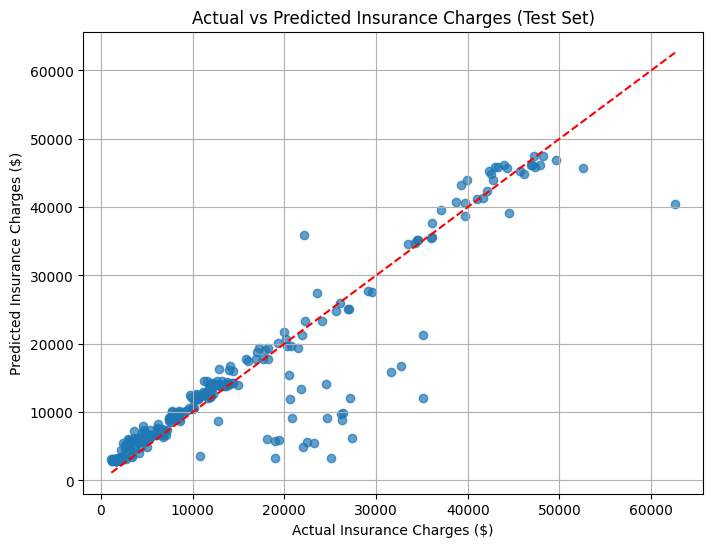

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_best_rf_test_pred, alpha=0.7)
plt.xlabel("Actual Insurance Charges ($)")  # Fixed label
plt.ylabel("Predicted Insurance Charges ($)")  # Fixed label
plt.title("Actual vs Predicted Insurance Charges (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.grid(True)
plt.show()

**The Random Forest model with max_depth=5, min_samples_split=10, and n_estimators=100 performed best due to the nature of the insurance dataset. The data includes a mix of categorical features (smoker, sex, region) and continuous features (age, BMI, children), which create clear decision boundaries—ideal for tree-based models.
A max_depth of 5 prevented overfitting while still capturing key interactions, such as smoker + age or smoker + BMI, which are critical for predicting insurance costs. Setting min_samples_split=10 ensured that splits occurred only when enough data was present, reducing variance and improving generalization.
Using 100 estimators gave stable results without unnecessary computational cost or overfitting. Since the dataset is relatively small (1,338 samples) with moderate complexity (6 features after encoding), deeper trees or more estimators didn’t improve performance and risked fitting to noise.
These settings struck the right bias-variance balance, leading to strong generalization and a solid R² score of 0.85 on the test data.**